In [1]:
import copy
import csv
from enum import Enum
import io
import json
import os
import typing as t

import cv2
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
)
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

/Users/vladimirkalajcidi/miniconda/envs/aidao2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils import (
    show_photos, 
    create_dataloader,
    train_epoch,
    test_epoch,
    plot_history,
    print_model_params_required_grad,
    PUBLIC_DATA_FOLDER_PATH,
    PUBLIC_DATA_DESCRIPTION_PATH,
)

In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [4]:
description = pd.read_csv(PUBLIC_DATA_DESCRIPTION_PATH, index_col='filename').sort_index()

In [5]:
class CarSide(Enum):
    FRONT = 0
    BACK = 1
    LEFT = 2
    RIGHT = 3
    UNKNOWN = 5
    
class FraudResolution(Enum):
    ALL_GOOD = 0
    LACK_OF_PHOTOS = 1
    BLURRY_PHOTO = 2
    SCREEN_PHOTO = 3
    DARK_PHOTO = 4
    INCOMPLETE_CAPTURE = 5
    RUDE_CONTENT = 6
    
class DamageResolution(Enum):
    NO_DEFECT = 0
    DEFECT = 1
    BAD_PHOTO = 2

In [6]:
IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGENET_RGB_STD = [0.229, 0.224, 0.225]
RESIZE_SIZE = (224, 224)


def pil_open(image_data: bytes) -> Image:
    return Image.open(io.BytesIO(image_data))


def preprocess(image_data: t.Optional[bytes]) -> torch.Tensor:
    return transforms.Compose([
        transforms.Lambda(pil_open),
        transforms.ToTensor(),
        transforms.Resize(RESIZE_SIZE),
        transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_STD),
    ])(image_data)

In [7]:
def get_damage_target(damage_resolution, *args):
    return int(damage_resolution != DamageResolution.NO_DEFECT.name)

damage_target = description.damage_verdict.apply(lambda x: get_damage_target(x))

In [8]:
def get_fraud_target(fraud_verdict, fraud_probability):
    return fraud_probability if fraud_verdict == "ALL_GOOD" else 0

fraud_target = description.apply(lambda row: get_fraud_target(row['fraud_verdict'], row['fraud_probability']), axis=1)

In [9]:
'''mask = fraud_target > 0.1

# Filter damage_target using the boolean mask
damage_target = damage_target[mask]'''

'mask = fraud_target > 0.1\n\n# Filter damage_target using the boolean mask\ndamage_target = damage_target[mask]'

In [10]:
BATCH_SIZE = 64
TRAIN_FRACTION = 0.7

total_size = damage_target.shape[0]
train_size = int(total_size * TRAIN_FRACTION)


train_loader = create_dataloader(
    img_dir_path=PUBLIC_DATA_FOLDER_PATH,
    target_map=damage_target[:train_size].to_dict(),
    description=description,
    batch_size=BATCH_SIZE,
    preprocessor=preprocess,
    num_load_workers=0,
)

test_loader = create_dataloader(
    img_dir_path=PUBLIC_DATA_FOLDER_PATH,
    target_map=damage_target[train_size:total_size].to_dict(),
    description=description,
    batch_size=BATCH_SIZE,
    preprocessor=preprocess,
    num_load_workers=0,
)

In [11]:
def train_model(
    model, 
    device, 
    train_loader, 
    test_loader, 
    epochs, 
    criterion, 
    optimizer, 
    scheduler=None, 
    save_best_model=True
):
    best_test_loss = None
    best_state_dict = None
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []
    
    model = model.to(device)
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}')
        train_loss, train_acc = train_epoch(
            model, 
            device,
            train_loader, 
            criterion, 
            optimizer
        )
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        
        if scheduler is not None:
            scheduler.step()
        
        test_loss, test_acc = test_epoch(model, device, test_loader, criterion)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
        
        if best_test_loss is None or test_loss < best_test_loss:
            best_test_loss = test_loss
            best_state_dict = copy.deepcopy(model.state_dict())
        
        clear_output()
        plot_history(
            train_loss_history, 
            test_loss_history, 
            train_acc_history, 
            test_acc_history
        )
    
    if save_best_model:
        model.load_state_dict(best_state_dict)
    
    return {
        'train_loss': train_loss_history, 
        'test_loss': test_loss_history,
        'train_acc': train_acc_history,
        'test_acc': test_acc_history
    }

### ResNet18 baseline

In [12]:
# load pretrained model
model = resnet18(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

# replace classifier
model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
    torch.nn.Sigmoid(),
)

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def BCELoss_class_weighted(weights):
    
    def loss(pred, target):
        pred = torch.clamp(pred, min=1e-7, max=1-1e-7)
        bce = -weights[1] * target * torch.log(pred) - (1 - target) * weights[0] * torch.log(1 - pred)
        return torch.sum(bce)

    return loss

criterion = BCELoss_class_weighted(weights=[0.5, 0.5])

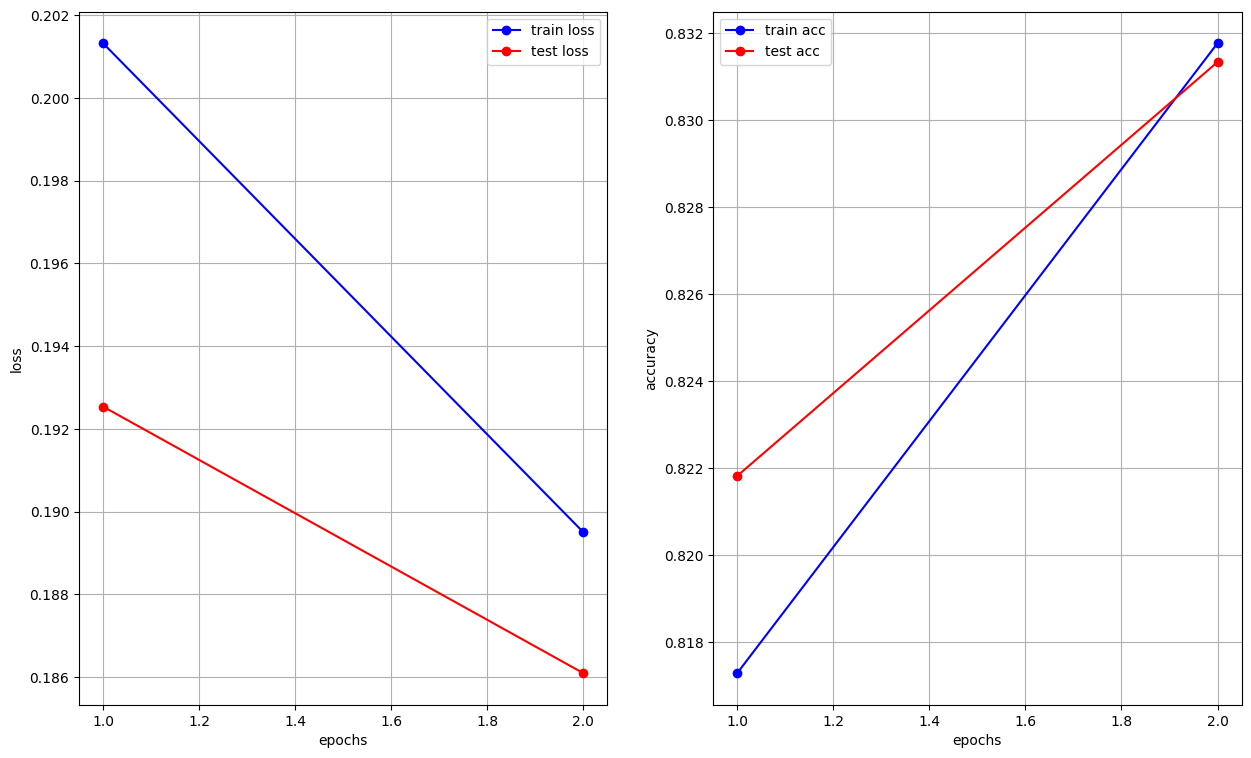

Epoch 3


  9%|▉         | 78/853 [00:26<04:35,  2.81it/s]

In [ ]:
print_model_params_required_grad(model)

resnet_simple_fraud_log = train_model(
    model=model, 
    device=device,
    train_loader=train_loader, 
    test_loader=test_loader, 
    epochs=3, 
    criterion=criterion, 
    optimizer=optimizer, 
)

In [ ]:
torch.save(model, 'baseline_damage_real_baseline.pt')

### Metric calculation

**NB**: There are only **filename**, **pass_id**, **plan_side** in private data description

In [ ]:
from sklearn.metrics import roc_auc_score

from utils import get_predictions

In [ ]:
model = torch.load('baseline_damage_real_baseline.pt')

In [ ]:
test_predictions = get_predictions(model, device, test_loader)

100%|██████████| 431/431 [01:48<00:00,  3.98it/s]


In [ ]:
test_verdicts = test_predictions.merge(
    description, 
    on=['pass_id', 'plan_side']
)

In [ ]:
test_verdicts

,pass_id,prediction,plan_side,fact_side,fraud_verdict,fraud_probability,damage_verdict,damage_probability
0,a17ffc0fae4e24d4,0.089982,back,back,ALL_GOOD,1.000000,NO_DEFECT,1.0
1,a17ffc0fae4e24d4,0.026331,front,front,ALL_GOOD,1.000000,NO_DEFECT,0.6
2,a17ffc0fae4e24d4,0.041270,right,right,ALL_GOOD,1.000000,NO_DEFECT,1.0
3,a18037c2900a0194,0.037593,back,back,ALL_GOOD,1.000000,DEFECT,0.8
4,a18037c2900a0194,0.046894,front,front,ALL_GOOD,1.000000,NO_DEFECT,0.8
...,...,...,...,...,...,...,...,...
27554,e6822bca408956ab,0.075136,front,front,ALL_GOOD,1.000000,NO_DEFECT,0.8
27555,e6822bca408956ab,0.045489,left,left,ALL_GOOD,1.000000,NO_DEFECT,0.8
27556,e6822bca408956ab,0.038422,right,right,ALL_GOOD,0.666667,NO_DEFECT,1.0
27557,e6834f5b356e791b,0.045500,back,back,ALL_GOOD,1.000000,NO_DEFECT,1.0


In [ ]:
def make_complex_target(row):
    real = int(
        row.plan_side != row.fact_side or 
        row.fraud_verdict != 'ALL_GOOD' or
        row.damage_verdict != 'NO_DEFECT'
    )
    return pd.Series(
        data=[row.pass_id, real, row.prediction],
        index=['pass_id', 'real', 'prediction'],
    )

# All predictions for each vehicle are aggregated into a single value, 
# and the metric is calculated based on the inspections.
test_verdicts = test_predictions.merge(
    description, 
    on=['pass_id', 'plan_side']
).apply(make_complex_target, axis=1).groupby('pass_id').max()

test_verdicts.head()

,real,prediction
pass_id,,
a17ffc0fae4e24d4,0,0.089982
a18037c2900a0194,1,0.109716
a1808d903ddf0130,0,0.086072
a180bc45994a05bb,1,0.128584
a18120533e755cdb,1,0.165571


In [ ]:
score = roc_auc_score(test_verdicts.real, test_verdicts.prediction)
print(f'simple fraud target roc_auc_score: {score}')

simple fraud target roc_auc_score: 0.777959741091585


### Make a submission file

In [ ]:
def solution():
    import typing as t
    import io

    import pandas as pd
    from PIL import Image
    import torch
    import torchvision.transforms as transforms

    from utils import (
        get_predictions, 
        create_dataloader,
        PRIVATE_DATA_FOLDER_PATH, 
        PRIVATE_DATA_DESCRIPTION_PATH,
    )

    BATCH_SIZE = 64
    IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_RGB_STD = [0.229, 0.224, 0.225]
    RESIZE_SIZE = (224, 224)


    def pil_open(image_data: bytes) -> Image:
        return Image.open(io.BytesIO(image_data))


    def preprocess(image_data: t.Optional[bytes]) -> torch.Tensor:
        return transforms.Compose([
            transforms.Lambda(pil_open),
            transforms.ToTensor(),
            transforms.Resize(RESIZE_SIZE),
            transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_STD),
        ])(image_data)

    device = torch.device('mps')
    model_damage = torch.load('model_damage.pt', map_location=device)
    model_fraud = torch.load('model_fraud.pt', map_location=device)

    description = pd.read_csv(PRIVATE_DATA_DESCRIPTION_PATH, index_col='filename').sort_index()
    # there is no real target in private data description
    dummy_target = {key: 0 for key in description.index}

    val_loader = create_dataloader(
        img_dir_path=PRIVATE_DATA_FOLDER_PATH,
        target_map=dummy_target,
        description=description,
        batch_size=BATCH_SIZE,
        preprocessor=preprocess,
        num_load_workers=0,
    )

    fraud = get_predictions(model_fraud, device, val_loader)
    if (fraud['prediction'] > 0.5):
        damage = get_predictions(model_damage, device, val_loader)
    else:
        solution = fraud
 
    solution = solution[['pass_id', 'prediction']].groupby('pass_id').max()
    solution.to_csv('./predictions.csv')

In [ ]:
solution_script = '''
import typing as t
import io

import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms

from utils import (
    get_predictions, 
    create_dataloader,
    PRIVATE_DATA_FOLDER_PATH, 
    PRIVATE_DATA_DESCRIPTION_PATH,
)

BATCH_SIZE = 64
IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGENET_RGB_STD = [0.229, 0.224, 0.225]
RESIZE_SIZE = (224, 224)


def pil_open(image_data: bytes) -> Image:
    return Image.open(io.BytesIO(image_data))


def preprocess(image_data: t.Optional[bytes]) -> torch.Tensor:
    return transforms.Compose([
        transforms.Lambda(pil_open),
        transforms.ToTensor(),
        transforms.Resize(RESIZE_SIZE),
        transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_STD),
    ])(image_data)

device = torch.device('cpu')
model = torch.load('baseline_damage.pt', map_location=device)
model = torch.load('baseline_damage.pt', map_location=device)

description = pd.read_csv(PRIVATE_DATA_DESCRIPTION_PATH, index_col='filename').sort_index()
# there is no real target in private data description
dummy_target = {key: 0 for key in description.index}

val_loader = create_dataloader(
    img_dir_path=PRIVATE_DATA_FOLDER_PATH,
    target_map=dummy_target,
    description=description,
    batch_size=BATCH_SIZE,
    preprocessor=preprocess,
    num_load_workers=0,
)

solution = get_predictions(model, device, val_loader)

solution = solution[['pass_id', 'prediction']].groupby('pass_id').max()
solution.to_csv('./predictions.csv')
'''

In [ ]:
# build the .zip to submit
import zipfile
import datetime

def make_zip_submission(model_path, solution_script):

    with open('run.py', 'w') as f_run:
        f_run.write(solution_script)

    with open('run.sh', 'w') as f_run_sh:
        f_run_sh.write('python run.py')

    with open('prepare.py', 'w') as f_run:
        f_run.write('print("do nothing")')

    with open('prepare.sh', 'w') as f_run_sh:
        f_run_sh.write('python prepare.py')

    with open('Makefile', 'w') as f_makefile:
        f_makefile.write(
'''prepare:
\tbash prepare.sh
run:
\tbash run.sh
''')

    submission_zip = zipfile.ZipFile(
        f"submission-{datetime.datetime.now()}.zip".replace(':', '-').replace(' ', '-'),
        "w"
    )
    submission_zip.write('./Makefile', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('run.py', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('run.sh', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('train.py', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('train.sh', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write(model_path, compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('utils.py', compress_type=zipfile.ZIP_DEFLATED)

    submission_zip.close()

In [ ]:
make_zip_submission(model_path='baseline_damage.pt', solution_script=solution_script)